In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import ir_datasets as irds
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import json
import re
from tqdm import tqdm
from transformers import AutoTokenizer
from langdetect import detect_langs
from language_tool_python import LanguageTool
from textstat import textstat
from functools import partial
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from pyserini.search.lucene import LuceneSearcher
from pyserini.index.lucene import IndexReader
from collections import Counter
import math

tqdm.pandas()
nltk.download('punkt')
tokenizer = AutoTokenizer.from_pretrained("sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco")
stemmer = PorterStemmer()
tool = LanguageTool('en-US')
DL19 = r"msmarco-passage/trec-dl-2019/judged"
DL20 = r"msmarco-passage/trec-dl-2020/judged"
MSMARCO_DEV = r"msmarco-passage/dev/small"
device = 'cuda'
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id
model.eval();

Matplotlib created a temporary cache directory at /scratch_local/esx208-1114693/tmp/matplotlib-f7or8f4z because the default path (/scratch_local/eickhoff/esx208/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: Cannot load default config file: No such file: (null)
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
[nltk_data] Downloading package punkt to
[nltk_data]     /home/eickhoff/esx208/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/scratch_local/esx208-1114693/ir_mech_interp/lib/python

In [2]:
searcher = LuceneSearcher.from_prebuilt_index('msmarco-v1-passage-slim')
reader = IndexReader.from_prebuilt_index('msmarco-v1-passage-slim')

Feb 05, 2025 10:30:07 PM org.apache.lucene.store.MMapDirectory lookupProvider


In [3]:
DL19_dataset = irds.load(DL19)
docs = pd.DataFrame(DL19_dataset.docs_iter()).set_index("doc_id")
data_trec_19 = pd.read_csv('/mnt/qb/work/eickhoff/esx208/MechIR/data/TFC1-data.tsv.gz', sep='\t')
data_trec_19 = data_trec_19[data_trec_19['perturbed'] == False][['docno', 'text']].drop_duplicates()
data_top_100_tas_b = json.load(open('/mnt/qb/work/eickhoff/esx208/axiomatic-ir/data/og_results.json', 'r'))

In [4]:
data_top_100_tas_b_docs = {doc_id for qid in data_top_100_tas_b for doc_id in data_top_100_tas_b[qid].keys()}
data_top_100_tas_b_docs = docs.loc[list(data_top_100_tas_b_docs)]

In [5]:
def tokenize_and_stem(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    processed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(processed_tokens)

def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    return ' '.join(tokens)

# data_top_100_tas_b_docs['text_tokenized'] = data_top_100_tas_b_docs['text'].progress_apply(tokenize)
# data_top_100_tas_b_docs['text_stemmed'] = data_top_100_tas_b_docs['text'].progress_apply(tokenize_and_stem)

In [6]:
# data_top_100_tas_b_docs.reset_index().to_csv('/mnt/qb/work/eickhoff/esx208/MechIR/data/data_texts_outlier_detection/data_top_100_tas_b_docs.tsv', sep='\t', index=False)

In [7]:
data_top_100_tas_b_docs = pd.read_csv('/mnt/qb/work/eickhoff/esx208/MechIR/data/data_texts_outlier_detection/data_top_100_tas_b_docs.tsv', sep='\t')

In [8]:
# data_trec_19['text_tokenized'] = data_trec_19['text'].progress_apply(tokenize)
# data_trec_19['text_stemmed'] = data_trec_19['text'].progress_apply(tokenize_and_stem)

In [9]:
# data_trec_19.to_csv('/mnt/qb/work/eickhoff/esx208/MechIR/data/data_texts_outlier_detection/data_trec_19.tsv', sep='\t', index=False)

In [10]:
data_trec_19 = pd.read_csv('/mnt/qb/work/eickhoff/esx208/MechIR/data/data_texts_outlier_detection/data_trec_19.tsv', sep='\t')

In [11]:
def get_english_probability(text):
    eng_prob = 0.0
    try:
        lang_probs = detect_langs(text)
        for prob in lang_probs:
            if prob.lang == 'en':
                eng_prob = prob.prob
    except:
        pass
    return eng_prob


def get_grammar_score(text):
    matches = tool.check(text)
    word_count = len(text.split()) # this is not a good way to count words TODO improve
    error_count = len(matches)
    error_ratio = error_count / word_count
    return error_ratio


def get_tfidf(text, reader):
    terms = text.split()
    tf = Counter(terms)
    num_docs = reader.stats()['documents']
    
    tfidf_scores = []
    for term, term_count in tf.items():
        try:
            df = reader.get_term_counts(term)[0]
        except:
            df = 0
        if df > 0:
            tf = term_count / len(terms)
            idf = math.log(num_docs / df)
            tfidf_scores.append(tf * idf)
    return tfidf_scores


def get_tf_injected_term(text, term):
    terms = text.split()
    tf = Counter(terms)
    if term in tf:
        return tf[term]
    else:
        return 0

def get_tfidf_injected_term(text, term, reader):
    tfidf_scores = get_tfidf(text, reader)
    if term in tfidf_scores:
        return tfidf_scores[term]
    else:
        return 0


def get_mean_tfidf(text, reader):
    tfidf = get_tfidf(text, reader)
    return np.mean(tfidf) if tfidf else 0.0


def get_std_tfidf(text, reader):
    tfidf = get_tfidf(text, reader)
    return np.std(tfidf) if tfidf else 0.0


def get_readability_scores(text, score_type='flesch_reading_ease'):
    text = text.lower()
    # Replace multiple whitespace with single space
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters but keep punctuation
    text = re.sub(r'[^\w\s.,!?;:\'\"\-]', '', text)
    
    return {
        'flesch_reading_ease': textstat.flesch_reading_ease(text),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'gunning_fog': textstat.gunning_fog(text),
        'smog_index': textstat.smog_index(text),
        'coleman_liau_index': textstat.coleman_liau_index(text),
        'automated_readability_index': textstat.automated_readability_index(text),
        'dale_chall_readability_score': textstat.dale_chall_readability_score(text)
    }
    
    
def process_batch(texts, model, tokenizer, max_length=512):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, 
                       truncation=True, max_length=max_length)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids = input_ids, 
                        attention_mask = attention_mask)
        
        target_ids = input_ids[:, 1:]
        logits = outputs.logits[:, :-1, :]
        attention_mask = attention_mask[:, 1:]
        log_probs = torch.log_softmax(logits, dim=-1)

        batch_size, seq_length = target_ids.shape
        batch_indices = torch.arange(batch_size).unsqueeze(1).to(device)
        seq_indices = torch.arange(seq_length).unsqueeze(0).to(device)
        token_log_probs = log_probs[batch_indices, seq_indices, target_ids]
        
        cross_entropy = -torch.sum(token_log_probs * attention_mask, dim=1) / attention_mask.sum(dim=1)
        perplexity = torch.exp2(cross_entropy)
            
    return perplexity.cpu().numpy().tolist()


def calculate_gpt2_entropy_batch(df, text_column='text', batch_size=32):    
    entropies = []
    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df[text_column].iloc[i:i+batch_size].tolist()
        batch_entropies = process_batch(batch_texts, model, tokenizer)
        entropies.extend(batch_entropies)
    
    return pd.Series(entropies, index=df.index, name='gpt2_entropy')


def compute_metrics(dataframe, reader):
    dataframe['tfidf_mean'] = dataframe['text_tokenized'].progress_apply(lambda x: get_mean_tfidf(x, reader))
    dataframe['tfidf_std'] = dataframe['text_tokenized'].progress_apply(lambda x: get_std_tfidf(x, reader))
    dataframe['doc_length'] = dataframe['text_tokenized'].apply(lambda x: len(x.split()))
    dataframe['english_probability'] = dataframe['text_tokenized'].progress_apply(get_english_probability)
    dataframe['num_sentences'] = dataframe['text'].progress_apply(lambda x: len(sent_tokenize(x)))
    # dataframe['grammar_score'] = dataframe['text'].progress_apply(get_grammar_score)
    readability_scores = dataframe['text'].progress_apply(get_readability_scores)
    readability_df = pd.DataFrame(readability_scores.tolist(), index=readability_scores.index)
    dataframe = pd.concat([dataframe, readability_df], axis=1)
    dataframe['gpt2_perplexity'] = calculate_gpt2_entropy_batch(dataframe)
    return dataframe

In [23]:
data_trec_19_metrics = compute_metrics(data_trec_19.copy(), reader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [01:38<00:00,  6.56it/s]


In [24]:
data_trec_19_metrics

,docno,text,text_tokenized,text_stemmed,tfidf_mean,tfidf_std,doc_length,english_probability,num_sentences,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score,gpt2_perplexity
0,1017759,Man and environment reciprocal relationship. T...,man and environment reciprocal relationship th...,man and environ reciproc relationship the rela...,0.112422,0.068332,48,0.999996,3,38.32,11.9,10.57,13.6,13.22,11.9,7.72,10.857648
1,1082489,Ethnographic research is a qualitative method ...,ethnographic research is a qualitative method ...,ethnograph research is a qualit method where r...,0.091375,0.055385,68,0.999997,3,23.05,15.7,17.90,16.7,17.24,18.4,12.66,11.594835
2,109063,1. Identify the fields of anthropology and maj...,1 identify the fields of anthropology and majo...,1 identifi the field of anthropolog and major ...,0.113128,0.064089,53,0.999995,7,36.59,12.6,13.87,15.0,14.38,14.0,10.47,8.230347
3,1160863,Human impact on the environment. Human impact ...,human impact on the environment human impact o...,human impact on the environ human impact on th...,0.194638,0.145845,37,0.999996,3,16.69,14.0,13.57,14.1,18.49,15.2,11.07,8.347539
4,1160871,Human impact on the environment. Human impact ...,human impact on the environment human impact o...,human impact on the environ human impact on th...,0.191243,0.142426,37,0.999997,3,16.69,14.0,13.57,14.1,18.20,14.9,10.65,8.149389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20641,8526087,The Aswan High Dam brought the Nile’s devastat...,the aswan high dam brought the niles devastati...,the aswan high dam brought the nile devast flo...,0.192417,0.094081,32,0.999996,1,55.92,13.4,16.55,0.0,12.31,18.9,11.14,20.546459
20642,8537921,Why have most Egyptians lived along the Nile R...,why have most egyptians lived along the nile r...,whi have most egyptian live along the nile riv...,0.149356,0.087365,35,0.999993,5,96.38,2.0,4.66,6.0,5.30,3.8,8.13,19.972704
20643,8742482,Egyptian Civilization. The basic element in th...,egyptian civilization the basic element in the...,egyptian civil the basic element in the length...,0.186715,0.124407,38,0.999998,3,60.65,9.5,9.71,0.0,11.26,11.6,9.57,9.973768
20644,937258,1 The people in Ancient Egypt divided Egypt in...,1 the people in ancient egypt divided egypt in...,1 the peopl in ancient egypt divid egypt into ...,0.117197,0.094978,54,0.999997,4,74.69,6.2,9.10,9.5,9.74,8.1,10.15,15.530478


In [25]:
data_trec_19_metrics.to_csv('/mnt/qb/work/eickhoff/esx208/MechIR/data/TFC1-data_w_metrics.tsv', sep='\t', index=False)

In [ ]:
data_top_100_tas_b_docs_metrics = compute_metrics(data_top_100_tas_b_docs.copy(), reader)

 46%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 291089/639266 [06:13<07:16, 797.87it/s]

In [ ]:
data_top_100_tas_b_docs_metrics

In [28]:
data_top_100_tas_b_docs_metrics.to_csv('/mnt/qb/work/eickhoff/esx208/MechIR/data/msmarco_tas_b_top_100_data_w_metrics.tsv', sep='\t', index=False)

In [25]:
data_trec_19

,docno,text,text_tokenized,text_stemmed,tfidf_mean,tfidf_variance,doc_length,num_sentences,english_probability,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score
0,1017759,Man and environment reciprocal relationship. T...,man and environment reciprocal relationship th...,man and environ reciproc relationship the rela...,0.000008,0.000002,48,3,0.999998,38.32,11.9,10.57,13.6,13.22,11.9,7.72
1,1082489,Ethnographic research is a qualitative method ...,ethnographic research is a qualitative method ...,ethnograph research is a qualit method where r...,0.000011,0.000002,68,3,0.999997,23.05,15.7,17.90,16.7,17.24,18.4,12.66
2,109063,1. Identify the fields of anthropology and maj...,1 identify the fields of anthropology and majo...,1 identifi the field of anthropolog and major ...,0.000009,0.000002,53,7,0.999995,36.59,12.6,13.87,15.0,14.38,14.0,10.47
3,1160863,Human impact on the environment. Human impact ...,human impact on the environment human impact o...,human impact on the environ human impact on th...,0.000007,0.000002,37,3,0.999997,16.69,14.0,13.57,14.1,18.49,15.2,11.07
4,1160871,Human impact on the environment. Human impact ...,human impact on the environment human impact o...,human impact on the environ human impact on th...,0.000007,0.000002,37,3,0.999997,16.69,14.0,13.57,14.1,18.20,14.9,10.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20641,8526087,The Aswan High Dam brought the Nile’s devastat...,the aswan high dam brought the niles devastati...,the aswan high dam brought the nile devast flo...,0.000008,0.000002,32,1,0.999997,55.92,13.4,16.55,0.0,12.31,18.9,11.14
20642,8537921,Why have most Egyptians lived along the Nile R...,why have most egyptians lived along the nile r...,whi have most egyptian live along the nile riv...,0.000008,0.000002,35,5,0.999998,96.38,2.0,4.66,6.0,5.30,3.8,8.13
20643,8742482,Egyptian Civilization. The basic element in th...,egyptian civilization the basic element in the...,egyptian civil the basic element in the length...,0.000007,0.000002,38,3,0.999997,60.65,9.5,9.71,0.0,11.26,11.6,9.57
20644,937258,1 The people in Ancient Egypt divided Egypt in...,1 the people in ancient egypt divided egypt in...,1 the peopl in ancient egypt divid egypt into ...,0.000008,0.000002,54,4,0.999998,74.69,6.2,9.10,9.5,9.74,8.1,10.15


In [50]:
data_top_100_tas_b_docs[['tfidf', 'doc_length', 'num_sentences']].describe()

,tfidf,doc_length,num_sentences
count,639266.000000,639266.000000,639266.000000
mean,0.000009,56.495767,3.388323
std,0.000002,22.366312,1.802577
min,0.000000,1.000000,1.000000
25%,0.000008,42.000000,2.000000
50%,0.000009,51.000000,3.000000
75%,0.000010,66.000000,4.000000
max,0.000018,244.000000,124.000000


In [51]:
data_trec_19[['tfidf', 'doc_length', 'num_sentences']].describe()

,tfidf,doc_length,num_sentences
count,20646.000000,20646.000000,20646.000000
mean,0.000009,55.220818,3.407052
std,0.000002,23.098421,1.922514
min,0.000002,3.000000,1.000000
25%,0.000008,40.000000,2.000000
50%,0.000009,49.000000,3.000000
75%,0.000010,65.000000,4.000000
max,0.000016,183.000000,68.000000


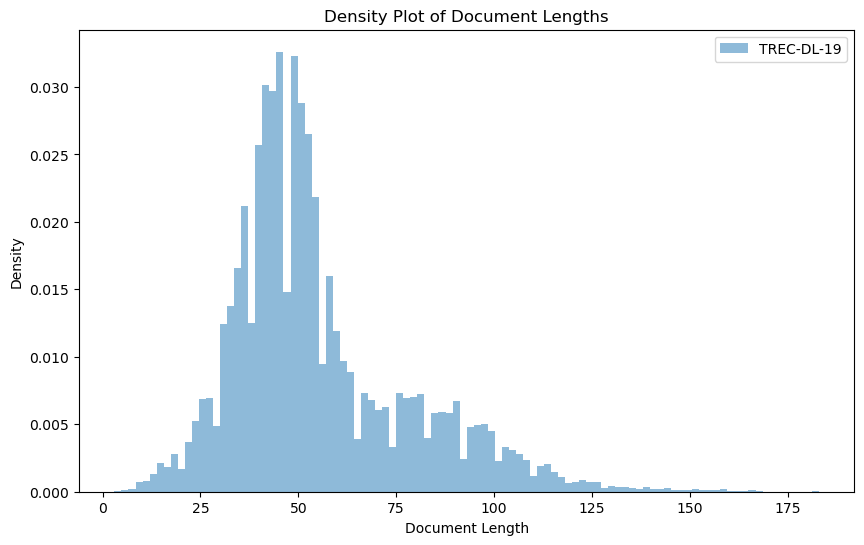

In [26]:
plt.figure(figsize=(10, 6))
# plt.hist(data_top_100_tas_b_docs['doc_length'], bins=100, alpha=0.5, label='TAS-B', density=True)
plt.hist(data_trec_19_metrics['doc_length'], bins=100, alpha=0.5, label='TREC-DL-19', density=True)
plt.title('Density Plot of Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Density')
plt.legend()
plt.show()

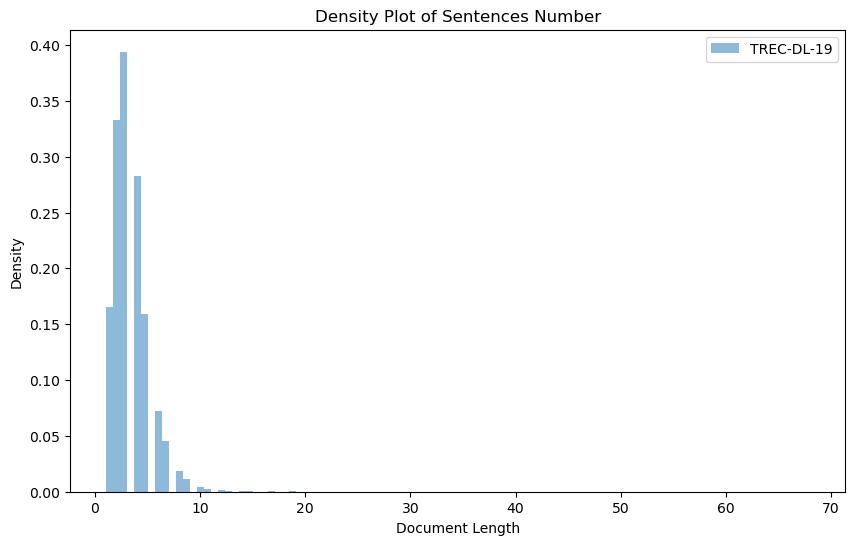

In [27]:
plt.figure(figsize=(10, 6))
# plt.hist(data_top_100_tas_b_docs['num_sentences'], bins=100, alpha=0.5, label='TAS-B', density=True)
plt.hist(data_trec_19_metrics['num_sentences'], bins=100, alpha=0.5, label='TREC-DL-19', density=True)
plt.title('Density Plot of Sentences Number')
plt.xlabel('Document Length')
plt.ylabel('Density')
plt.legend()
plt.show()

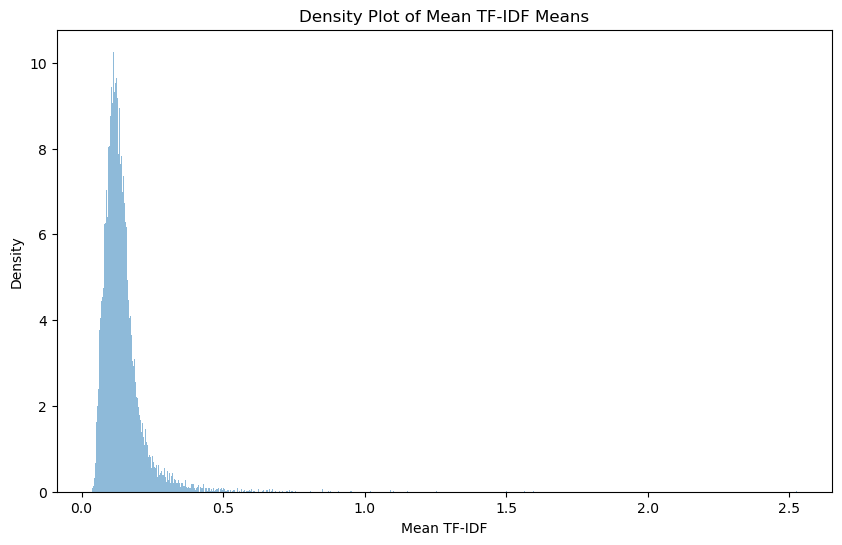

In [28]:
plt.figure(figsize=(10, 6))
# plt.hist(data_top_100_tas_b_docs['tfidf_mean'], bins=1000, alpha=0.5, label='TAS-B', density=True)
plt.hist(data_trec_19_metrics['tfidf_mean'], bins=1000, alpha=0.5, label='TREC-DL-19', density=True)
plt.title('Density Plot of Mean TF-IDF Means')
plt.xlabel('Mean TF-IDF')
plt.ylabel('Density')
plt.show()

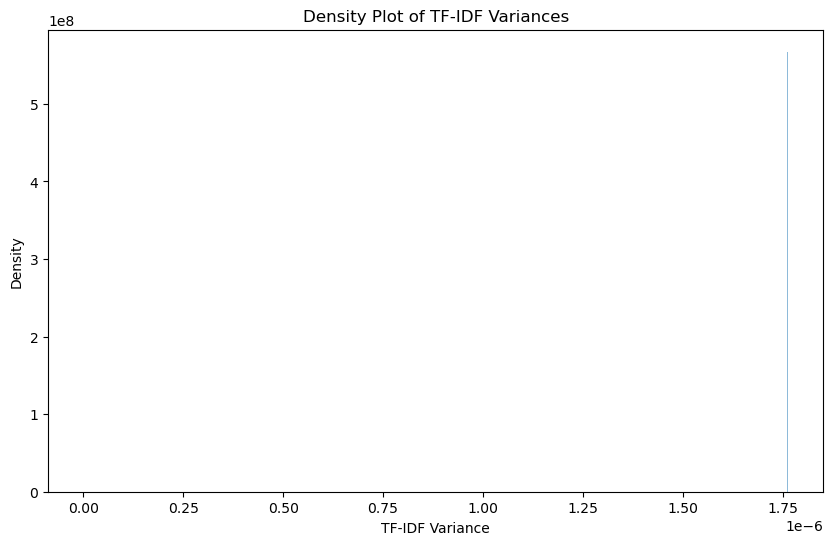

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(data_top_100_tas_b_docs['tfidf_variance'], bins=1000, alpha=0.5, label='TAS-B', density=True)
#plt.hist(data_trec_19['tfidf_variance'], bins=1000, alpha=0.5, label='TREC-DL-19', density=True)
plt.title('Density Plot of TF-IDF Variances')
plt.xlabel('TF-IDF Variance')
plt.ylabel('Density')
plt.show()